In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from collections import defaultdict
from collections.abc import Iterable
from functools import partial
import gc
import inspect
import matplotlib.pyplot as plt
import numpy as np
from operator import gt, lt, add, sub
import os
import pandas as pd
from tabulate import tabulate
import shutil
from sklearn.metrics import (accuracy_score, dcg_score, roc_auc_score, 
                             precision_score, recall_score)
from textblob import TextBlob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import Adam
from tqdm.auto import tqdm
import warnings

from accio.s3tool import S3tool
from htools import (load, save, hdir, LoggerMixin, eprint, assert_raises,
                    auto_repr, valuecheck, debug, wrapmethods)
from ml_htools.torch_utils import (ModelMixin, variable_lr_optimizer,
                                   update_optimizer, DEVICE, stats, adam)

In [ ]:
# Reproducible testing.
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
class Data(Dataset):
    
    def __init__(self, n=64, dim=2):
        self.x = torch.rand(n, dim).float()
        self.y = torch.clamp(
            (self.x[:, 0]*.75 + self.x[:, 1]*.25).round(), 0, 1
        ).abs().unsqueeze(-1)
        
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
    def __len__(self):
        return len(self.x)

In [ ]:
class MulticlassData(Dataset):
    
    def __init__(self, n=64, dim=2):
        self.x = torch.rand(n, dim).float()
        # Integer labels between 0 and 4, inclusive.
        self.y = torch.clamp(
            torch.round(
                torch.randint(6, (n, 1)).float() 
                * (self.x[:, 0]*.75 + self.x[:, 1]*.25).unsqueeze(-1)
            ), 0, 4).long().flatten()
        
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
    def __len__(self):
        return len(self.x)

In [ ]:
ypred_ = torch.rand(5, 2)
y_ = torch.tensor([0, 1, 1, 0, 1])
ypred_, y_

(tensor([[0.4963, 0.7682],
         [0.0885, 0.1320],
         [0.3074, 0.6341],
         [0.4901, 0.8964],
         [0.4556, 0.6323]]), tensor([0, 1, 1, 0, 1]))

In [ ]:
ypred_.softmax(-1).argmax(-1).dtype

torch.int64

In [ ]:
F.cross_entropy(ypred_, y_)

tensor(0.7157)

In [ ]:
ypred_.softmax(-1)

tensor([[0.4324, 0.5676],
        [0.4891, 0.5109],
        [0.4191, 0.5809],
        [0.3998, 0.6002],
        [0.4559, 0.5441]])

In [ ]:
F.binary_cross_entropy(ypred_.softmax(-1)[:, -1], y_.float())

tensor(0.7157)

In [ ]:
F.cross_entropy(ypred_, y_)

tensor(0.7157)

In [ ]:
F.nll_loss(ypred_.log_softmax(-1), y_)

tensor(0.7157)

In [ ]:
yhat_ml = torch.randn(5, 4)
y_ml = torch.tensor([[0, 1, 0, 0], [1, 1, 1, 1], [0, 0, 1, 1], [0, 0, 0, 0], [1, 0, 0, 0]])
yhat_ml, y_ml

(tensor([[ 0.4913, -0.2041, -0.0885,  0.5239],
         [-0.1435, -0.1116, -0.6136,  0.0316],
         [-0.4927,  0.2484,  0.4397,  0.1124],
         [-0.8411, -2.3160, -0.1023,  0.7924],
         [-0.2897,  0.0525,  0.5229,  2.3022]]), tensor([[0, 1, 0, 0],
         [1, 1, 1, 1],
         [0, 0, 1, 1],
         [0, 0, 0, 0],
         [1, 0, 0, 0]]))

In [ ]:
(torch.sigmoid(yhat_ml) > 0.5).float()

tensor([[1., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 1., 1., 1.],
        [0., 0., 0., 1.],
        [0., 1., 1., 1.]])

In [ ]:
F.binary_cross_entropy_with_logits(yhat_ml, y_ml.float(), reduction='none')

tensor([[0.9687, 0.8004, 0.6499, 0.9890],
        [0.7675, 0.7505, 1.0463, 0.6775],
        [0.4768, 0.8250, 0.4973, 0.6385],
        [0.3585, 0.0941, 0.6433, 1.1659],
        [0.8484, 0.7197, 0.9884, 2.3976]])

In [ ]:
-y_ml.float() * torch.log(torch.sigmoid(yhat_ml))

tensor([[0.0000, 0.8004, 0.0000, 0.0000],
        [0.7675, 0.7505, 1.0463, 0.6775],
        [0.0000, 0.0000, 0.4973, 0.6385],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.8484, 0.0000, 0.0000, 0.0000]])

In [ ]:
-(1 - y_ml.float()) * torch.log(1 - torch.sigmoid(yhat_ml))

tensor([[0.9687, 0.0000, 0.6499, 0.9890],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.4768, 0.8250, 0.0000, 0.0000],
        [0.3585, 0.0941, 0.6433, 1.1659],
        [0.0000, 0.7197, 0.9884, 2.3976]])

**Note: F.cross_entropy combines F.log_softmax and F.nll_loss. However, for last_act we still want F.softmax, as this will create interpretable probabilities.**

In [ ]:
class Trainer(LoggerMixin):
    
    @valuecheck
    def __init__(self, net, ds_train, ds_val, dl_train, dl_val,
                 criterion, mode:('binary', 'multiclass', 'regression'),
                 out_dir, bucket=None, optim_type=Adam, eps=1e-3, 
                 last_act=None, threshold=0.5, metrics=None, callbacks=None,
                 device=DEVICE):
        """An object to handle model training. This makes it easy for us to
        save model weights, optimizer state, datasets and dataloaders all
        at once.
        
        Parameters
        ----------
        net: BaseModel (inherits from nn.Module)
            A pytorch model. The BaseModel implementation from this library
            should be used, since Trainer relies on its `unfreeze` method.
        ds_train: torch.utils.data.Dataset
            Training dataset.
        ds_val: torch.utils.data.Dataset
            Validation dataset.
        dl_train: torch.utils.data.DataLoader
            Training dataloader. Lazily retrieves items from train dataset.
        dl_val: torch.utils.data.DataLoader
            Validation dataloader. Lazily retrieves items from val dataset.
        criterion: callable
            Typically a PyTorch loss function, but you could define your
            own as long as it accepts the same arguments in the same order.
            This can be a function (e.g. F.cross_entropy) or a callable
            object (e.g. nn.CrossEntropyLoss(). Notice that this is the
            object, not the class.)
        mode: str
            Specifies the problem type. Multi-label classification is 
            considered 'binary' as well since each example receives a binary
            prediction for each class.
        out_dir: str
            The path to an output directory where logs, model weights, and
            more will be stored. If it doesn't already exist, it will be 
            created.
        bucket: str
            S3 bucket to store data. This can be used with the S3Upload
            callback to automatically upload all files to S3 when training
            completes.
        optim_type: torch.optim callable
            Callable optimizer. The default is Adam. Notice that this is the 
            class, not the object.
        eps: float
            The value of epsilon that will be passed to our optimizer. 
            We use a larger value than PyTorch's default, which empirically
            can cause exploding gradients.
        last_act: callable or None
            Last activation function to be applied outside the model. 
            For example, for a binary classification problem, if we choose
            to use binary_cross_entropy_with_logits loss but want to compute
            some metric using soft predictions, we would pass in torch.sigmoid
            for `last_act`. For a multi-class problem using F.cross_entropy 
            loss, we would need to pass in F.softmax to compute predicted 
            probabilities.  Remember this is ONLY necessary if all of the 
            following conditions are met:
            1. It is a classification problem.
            2. We have excluded the final activation from our model for 
            numerical stability reasons. (I.E. the loss function has the 
            the final activation built into it.)
            3. We wish to compute 1 or more metrics based on soft predictions,
            such as AUC-ROC.
        threshold: float or None
            For a classification problem, pass in the decision threshold to
            use when converting soft predictions to hard predictions. For a
            regression problem, pass in None.
        metrics: list
            A list of callable metrics. These will be computed on both the
            train and validation sets during training. To maintain 
            compatibility with scikit-learn metrics, they should accept 
            two arguments: y_true, followed by either y_score (for soft
            predictions) or y_pred (for hard predictions). The name and
            order of these arguments matters. If other arguments are
            required, pass in a partial with those values specified.
        callbacks: list[TorchCallback]
            List of callbacks. These will be evaluated during model training
            and can be used to track stats, adjust learning rates, clip
            gradients, etc.
        device: torch.device
            Trainer will place the model and current batch of data on this
            device during training. The default value uses a GPU if one is
            available, otherwise falls back to a CPU.
            
        Reference
        ---------
        Classification Loss Function (k = number of classes)

        Loss                               y shape  yhat shape  dtype
        --------------------------------------------------------------        
        binary_cross_entropy_with_logits   (bs, 1)  (bs, 1)     float
        "" (multilabel case)               (bs, k)  (bs, k)     float
        cross_entropy                      (bs,)    (bs, k)     long
        """
        self.net = net
        self.ds_train, self.ds_val = ds_train, ds_val
        self.dl_train, self.dl_val = dl_train, dl_val
        # Optim created in fit() method. Must be after net is on the GPU.
        self.optim_type = optim_type
        self.optim = None
        self.eps = eps
        self.criterion = criterion
        self.mode = mode
        self.device = DEVICE
        self.last_act = last_act
        self.thresh = threshold
        self._stop_training = False
        # For now, only print logs. During training, a file will be created.
        self.logger = self.get_logger()
    
        # Storage options.
        self.out_dir = out_dir
        self.bucket = bucket
        os.makedirs(out_dir, exist_ok=True)
        
        # Dict makes it easier to adjust callbacks after creating model.
        self.callbacks = {}
        self.add_callbacks(*[BasicConfig(), StatsHandler(), MetricPrinter()] 
                           + (callbacks or []))
        self.metrics = [batch_size] + (metrics or [])
    
    def save(self, fname):
        """Save a Trainer for later use. This includes the model, optimizer,
        datasets, and data loaders.
        
        Parameters
        ----------
        fname: str
            File name to save to (not a full path - the trainer already has
            an `out_dir` attribute which will be used). The extension must
            be .pkl or .zip, and will determine whether the trainer is 
            compressed.
            
        Returns
        -------
        None
        """
        save(self, os.path.join(self.out_dir, fname))
        
    def load(self, fname):
        """This lets a trainer load a previously saved state. This is NOT
        an in-place operation: the new trainer is simply returned.
        
        Parameters
        ----------
        fname: str
            Name of file where Trainer object is stored. Must end in either
            .zip or .pkl. Do not include the full path. This automatically
            checks the output directory.
            
        Returns
        -------
        Trainer
        
        Examples
        --------
        trainer = Trainer(...)
        trainer.fit(...)
        trainer.save('v1')
        trainer = trainer.load('v1')
        """
        return load(self, os.path.join(self.out_dir, fname))
    
    @staticmethod
    def from_file(path):
        """Ths lets us load a previously saved Trainer. Unlike load(), this
        does not require us to have a Trainer instance first. The intent is
        that load() works well when within a single Jupyter notebook session,
        but when returning to work on a different day, we may not have a live
        instance of Trainer and a staticmethod lets us load without
        remembering all the arguments used at initialization time.
        
        Parameters
        ----------
        path: str
            Full path to saved file. This differs from load() because here, we
            don't have an instance with an out_dir attribute to check.
            
        Returns
        -------
        Trainer
        """
        return load(path)
    
    def add_callbacks(self, *callbacks):
        """Attach additional callbacks to Trainer. Note that callback order 
        will be determined by their `priority` attribute, not insertion
        order.
            
        Parameters
        ----------
        callbacks: TorchCallback
            One or more callbacks to add. 
            
        Returns
        -------
        None
        """
        self.callbacks.update({type(cb).__name__: cb for cb in callbacks})
        self.callbacks = dict(sorted(self.callbacks.items(),
                                     key=lambda x: x[1].priority))
    
    def add_metrics(self, *metrics):
        """Add additional metrics to track. See the `metrics` parameter in 
        the __init__ docstring for more details.
        
        Parameters
        ----------
        metrics: callable
        
        Returns
        -------
        None
        """
        self.metrics.extend(metrics)
    
    def fit(self, epochs, lrs=3e-3, lr_mult=1.0, **kwargs): 
        """Train the model.
        
        Parameters
        ----------
        epochs: int
            Number of epochs to train for.
        lrs: float or Iterable(float)
            Pass in one or more learning rates. If lr_mult < 1, these
            will be the max LR(s). If the number of values matches the number
            of layer groups in the model, they will be matched accordingly,
            with the first layer is assigned the first LR. If 1 LR is passed
            in and lr_mult < 1, the multiplier will be used to create an
            appropriate number of LRs. Example: for a network with 3 groups,
            lrs=3e-3 and lr_mult=0.1 will produce LRs of [3e-5, 3e-4, 3e-3].
        lr_mult: float
            Multiplier used to compute additional learning rates if needed.
            See `update_optimizer()` for details.
        kwargs: any
            Pass in clean=True to remove existing files in out_dir.
        """
        stats = defaultdict(list)
        sum_i = 0
        _ = self.decide_stop('on_train_begin', epochs, lrs, lr_mult, **kwargs)
        for e in range(epochs):
            _ = self.decide_stop('on_epoch_begin', e, stats, None)
            for i, batch in enumerate(tqdm(self.dl_train)):
                sum_i += 1
                *xb, yb = map(lambda x: x.to(self.device), batch)
                self.optim.zero_grad()
                _ = self.decide_stop('on_batch_begin', i, sum_i, stats)
                
                # Forward and backward passes.
                y_score = self.net(*xb)
                loss = self.criterion(y_score, yb)
                loss.backward()
                self.optim.step()
                
                # Separate because callbacks are only applied during training.
                self._update_stats(stats, loss, yb, y_score.detach())
                if self.decide_stop('on_batch_end', i, sum_i, stats): break
            
            # If on_batch_end callback halts training, else block is skipped.  
            else: 
                val_stats = self.validate()
                if self.decide_stop('on_epoch_end', e, stats, val_stats): break
                continue
            break  
        _ = self.decide_stop('on_train_end', e, stats, val_stats)
    
    def validate(self, dl_val=None):
        """Evaluate the model on a validation set.
        
        Parameters
        ----------
        dl_val: torch.utils.data.DataLoader
            Accepting an optional dataloader allows the user to pass in 
            different loaders after training for evaluation. If None is
            passed in, self.dl_val is used.
        """
        dl_val = self.dl_val or dl_val
        val_stats = defaultdict(list)
        self.net.eval()
        with torch.no_grad():
            for batch in dl_val:
                *xb, yb = map(lambda x: x.to(self.device), batch)
                y_score = self.net(*xb)
                loss = self.criterion(y_score, yb)
                self._update_stats(val_stats, loss, yb, y_score)
        return val_stats
        
    def _update_stats(self, stats, loss, yb, y_score):
        """Update stats in place.
        
        Parameters
        ----------
        stats: defaultdict[str, list]
        loss: torch.Tensor
            Tensor containing single value (mini-batch loss).
        yb: torch.Tensor
            Mini-batch of labels.
        y_score: torch.Tensor
            Mini-batch of raw predictions. In the case of 
            classification, these may still need to be passed
            through a sigmoid or softmax.
            
        Returns
        -------
        None
        """
        # Final activation often excluded from network architecture.
        try:
            y_score = self.last_act(y_score)
        except TypeError:
            pass
        
        # Convert soft predictions to hard predictions.
        if self.mode == 'binary':
            # In multi-label case, this will have shape (bs, k).
            y_pred = (y_score > self.thresh).float()
        elif self.mode == 'multiclass':
            y_pred = y_score.argmax(-1)
        elif self.mode == 'regression':
            y_pred = y_score
            
        stats['loss'].append(loss.detach().cpu().numpy().item())
        for m in self.metrics:
            yhat = y_pred if hasarg(m, 'y_pred') else y_score
            stats[m.__name__.replace('_score', '')].append(m(yb, yhat))
        
    def decide_stop(self, attr, *args, **kwargs):
        """Evaluates each of the trainer's callbacks. If any callback
        encounters a condition that signals that training should halt,
        it will set the attribute trainer._stop_training to True.
        This method returns that value. By design, all callbacks will
        be called before stopping training.
        
        Parameters
        ----------
        attr: str
            Determines which method to call for each callback.
            One of ('on_train_begin', 'on_train_end', 'on_batch_begin',
            'on_batch_end', 'on_epoch_begin', 'on_epoch_end').
        args, kwargs: any
            Additional arguments to pass to the callbacks.
            
        Returns
        -------
        bool: If True, halt training.
        """
        self._stop_training = False
        # Pass model object as first argument to callbacks.
        for cb in self.callbacks.values():
            getattr(cb, attr)(self, *args, **kwargs)
        return self._stop_training
    
    def unfreeze(self, n_layers=None, n_groups=None, msg_pre=''):
        """Pass in either the number of layers or number of groups to 
        unfreeze. Unfreezing always starts at the end of the network and moves
        backward (e.g. n_layers=1 will unfreeze the last 1 layer, or n_groups=2 
        will unfreeze the last 2 groups.) Remember than weights and biases are 
        treated as separate layers.
        
        Parameters
        ----------
        n_layers: int or None
            Number of layers to unfreeze.
        n_groups: int or None
            Number of layer groups to unfreeze. For this to work, the model
            must define an attribute `groups` containing the layer groups.
            Each group can be a layer, a nn.Sequential object, or 
            nn.Module.
        msg_pre: str
            Optional: add a prefix to the logged message. For example,
            this can be used to record the epoch that unfreezing occurred
            during.
        """
        mode = 'layers' if n_layers is not None else 'groups'
        msg_pre += f'Unfreezing last {n_layers or n_groups} {mode}.'
        self.logger.info(msg_pre)
        self.net.unfreeze(n_layers, n_groups)
            
    def freeze(self):
        """Freeze whole network. Mostly used for testing."""
        self.logger.info('Freezing whole network.')
        self.net.unfreeze(n_layers=0)
    
    def cleanup(self, sentinel=None, confirmed=False):
        """Delete output directory. An empty directory with the same name
        will be created in its place.
        
        Parameters
        ----------
        sentinel: None
            Placeholder to force user to pass confirmed as keyword arg.
        confirmed: bool
            Placeholder variable. This is just intended to force the user
            to confirm their desire to delete files before doing it. If
            True, the directory will be deleted. (Technically, any truthy
            value will work.)
            
        Returns
        -------
        None
        """
        if not confirmed: 
            self.logger.info('Missing confirmation, cleanup skipped.')
            return
        self.logger.info('Removing files from output directory.')
        shutil.rmtree(self.out_dir)
        os.makedirs(self.out_dir)
        
    def __repr__(self):
        r = (f'Trainer(criterion={repr(self.criterion.__name__)}, '
             f'out_dir={repr(self.out_dir)}, bucket={repr(self.bucket)})'
             f'\n\nDatasets: {len(self.ds_train)} train rows, '
             f'{len(self.ds_val)} val rows'
             f'\n\nOptimizer: {repr(self.optim)}'
             f'\n\n{repr(self.net)})')
        return r

In [ ]:
class BaseModel(nn.Module):
    
    def unfreeze(self, n_layers=None, n_groups=None):
        """Pass in either the number of layers or number of groups to 
        unfreeze. Unfreezing always starts at the end of the network and moves
        backward (e.g. n_layers=1 will unfreeze the last 1 layer, or n_groups=2 
        will unfreeze the last 2 groups.) Remember than weights and biases are 
        treated as separate layers.
        
        Parameters
        ----------
        n_layers: int or None
            Number of layers to unfreeze.
        n_groups: int or None
            Number of layer groups to unfreeze. For this to work, the model
            must define an attribute `groups` containing the layer groups.
            Each group can be a layer, a nn.Sequential object, or 
            nn.Module.
        """
        if n_groups is not None: 
            self._unfreeze_by_group(n_groups)
            return

        length = len(self)
        for i, p in enumerate(self.parameters()):
            p.requires_grad = i >= length - n_layers
            
    def freeze(self):
        """Freeze whole network. Mostly used for testing."""
        self.unfreeze(n_layers=0)
        
    def _unfreeze_by_group(self, n_groups):
        """Helper for unfreeze() method.
        
        Parameters
        ----------
        n_groups: int
            Number of groups to unfreeze, starting at the end of the network.
        """
        length = len(self.groups)
        for i, group in enumerate(self.groups):
            setting = i >= length - n_groups
            for p in group.parameters():
                p.requires_grad = setting
                
    def __len__(self):
        """Number of parameter matrices in model (basically number of layers, 
        except that biases are counted separately).
        """
        return sum(1 for p in self.parameters())
    
    def dims(self):
        """Get shape of each layer's weights."""
        return [tuple(p.shape) for p in self.parameters()]

    def trainable(self):
        """Check which layers are trainable."""
        return [(tuple(p.shape), p.requires_grad) for p in self.parameters()]

    def weight_stats(self):
        """Check mean and standard deviation of each layer's weights."""
        return [stats(p.data, 3) for p in self.parameters()]

    def plot_weights(self):
        """Plot histograms of each layer's weights."""
        n_layers = len(self.dims())
        fig, ax = plt.subplots(n_layers, figsize=(8, n_layers * 1.25))
        if not isinstance(ax, Iterable): ax = [ax]
        for i, p in enumerate(self.parameters()):
            ax[i].hist(p.data.flatten())
            ax[i].set_title(f'Shape: {tuple(p.shape)} Stats: {stats(p.data)}')
        plt.tight_layout()
        plt.show()

In [ ]:
class SimpleModel(BaseModel):
    
    def __init__(self, dim):
        super().__init__()  
        self.fc1 = nn.Linear(dim, 2)
        self.fc2 = nn.Linear(2, 1)
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        return self.fc2(x)

In [ ]:
class GroupedModel(BaseModel):
    
    def __init__(self, dim):
        super().__init__()  
        g1 = nn.Sequential(
            nn.Linear(dim, 8),
            nn.LeakyReLU(),
            nn.Linear(8, 4),
            nn.LeakyReLU()
        )
        g2 = nn.Linear(4, 1)
        self.groups = nn.ModuleList([g1, g2])
        
    def forward(self, x):
        for group in self.groups:
            x = group(x)
        return x

In [ ]:
DIM = 2

In [ ]:
snet = SimpleModel(DIM)
snet

SimpleModel(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=1, bias=True)
)

In [ ]:
optim = variable_lr_optimizer(snet, 2e-3)
optim

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.002
    weight_decay: 0
)

In [ ]:
with assert_raises(ValueError) as ar:
    optim = variable_lr_optimizer(snet, [3e-3, 1e-1])
    optim

As expected, got ValueError(Received more learning rates than layer groups.).


In [ ]:
update_optimizer(optim, 1e-3, 0.5)
optim

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.001
    weight_decay: 0
)

In [ ]:
snet.freeze()
for n in range(5):
    snet.unfreeze(n_layers=n)
    print(n, snet.trainable())

0 [((2, 2), False), ((2,), False), ((1, 2), False), ((1,), False)]
1 [((2, 2), False), ((2,), False), ((1, 2), False), ((1,), True)]
2 [((2, 2), False), ((2,), False), ((1, 2), True), ((1,), True)]
3 [((2, 2), False), ((2,), True), ((1, 2), True), ((1,), True)]
4 [((2, 2), True), ((2,), True), ((1, 2), True), ((1,), True)]


In [ ]:
snet.freeze()
with assert_raises(AttributeError) as ar:
    for n in range(3):
        snet.unfreeze(n_groups=n)
        print(n, snet.trainable())

As expected, got AttributeError('SimpleModel' object has no attribute 'groups').


In [ ]:
gnet = GroupedModel(DIM)
gnet

GroupedModel(
  (groups): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=8, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
    (1): Linear(in_features=4, out_features=1, bias=True)
  )
)

In [ ]:
optim = variable_lr_optimizer(gnet, [1e-3, 3e-3])
optim

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.001
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.003
    weight_decay: 0
)

In [ ]:
update_optimizer(optim, 2e-3, lr_mult=1/3)
optim

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.0006666666666666666
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.002
    weight_decay: 0
)

In [ ]:
variable_lr_optimizer(gnet, 1e-3)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.001
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.001
    weight_decay: 0
)

In [ ]:
variable_lr_optimizer(gnet, 1e-3, lr_mult=0.5)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.0005
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.001
    weight_decay: 0
)

In [ ]:
gnet.freeze()
for n in range(3):
    gnet.unfreeze(n_groups=n)
    print(n, gnet.trainable())

0 [((8, 2), False), ((8,), False), ((4, 8), False), ((4,), False), ((1, 4), False), ((1,), False)]
1 [((8, 2), False), ((8,), False), ((4, 8), False), ((4,), False), ((1, 4), True), ((1,), True)]
2 [((8, 2), True), ((8,), True), ((4, 8), True), ((4,), True), ((1, 4), True), ((1,), True)]


In [ ]:
gnet.freeze()
for n in range(7):
    gnet.unfreeze(n_layers=n)
    print(n, gnet.trainable())

0 [((8, 2), False), ((8,), False), ((4, 8), False), ((4,), False), ((1, 4), False), ((1,), False)]
1 [((8, 2), False), ((8,), False), ((4, 8), False), ((4,), False), ((1, 4), False), ((1,), True)]
2 [((8, 2), False), ((8,), False), ((4, 8), False), ((4,), False), ((1, 4), True), ((1,), True)]
3 [((8, 2), False), ((8,), False), ((4, 8), False), ((4,), True), ((1, 4), True), ((1,), True)]
4 [((8, 2), False), ((8,), False), ((4, 8), True), ((4,), True), ((1, 4), True), ((1,), True)]
5 [((8, 2), False), ((8,), True), ((4, 8), True), ((4,), True), ((1, 4), True), ((1,), True)]
6 [((8, 2), True), ((8,), True), ((4, 8), True), ((4,), True), ((1, 4), True), ((1,), True)]


# Callbacks

In [ ]:
@auto_repr
class TorchCallback:
    
    def on_train_begin(self, trainer, epochs, lrs, lr_mult, **kwargs):
        pass
    
    def on_train_end(self, trainer, epoch, stats, val_stats):
        pass
    
    def on_epoch_begin(self, trainer, epoch, stats, val_stats):
        pass

    def on_epoch_end(self, trainer, epoch, stats, val_stats):
        pass
    
    def on_batch_begin(self, trainer, i, sum_i, stats):
        pass
    
    def on_batch_end(self, trainer, i, sum_i, stats):
        pass

In [ ]:
class BasicConfig(TorchCallback):
    """Handles basic model tasks like putting the model on the GPU
    and switching between train and eval modes.
    """
    
    def __init__(self, priority=0):
        self.priority = priority
    
    def on_train_begin(self, trainer, epochs, lrs, lr_mult, **kwargs):
        trainer.net.to(DEVICE)
        trainer.optim = variable_lr_optimizer(
            trainer.net, lrs, lr_mult, trainer.optim_type, trainer.eps
        )
        if kwargs.get('clean') is True: trainer.cleanup(confirmed=True)

    def on_epoch_begin(self, trainer, *args, **kwargs):
        trainer.net.train()
        
    def on_train_end(self, trainer, *args, **kwargs):
        trainer.logger.info('Training complete. Model in eval mode.')
        trainer.net.eval()

In [ ]:
class StatsHandler(TorchCallback):
    """This updates metrics at the end of each epoch to account for
    potentially varying batch sizes.
    """
    
    def __init__(self, priority=5):
        self.priority = priority
        
    def on_epoch_begin(self, trainer, epoch, stats, val_stats):
        """Resets stats at the start of each epoch."""
        stats.clear()
        
    def on_epoch_end(self, trainer, epoch, stats, val_stats):
        """Computes (possibly weighted) averages of mini-batch stats
        at the end of each epoch.
        """
        for group in (stats, val_stats):
            for k, v in group.items():
                if k == 'batch_size': continue
                group[k] = np.average(v, weights=group['batch_size'])
            group.pop('batch_size')

In [ ]:
class MetricPrinter(TorchCallback):
    """Prints metrics at the end of each epoch. This is one of the 
    default callbacks provided in BaseModel - it does not need to
    be passed in explicitly.
    """
    
    def __init__(self, priority=10):
        self.priority = priority
        
    def on_train_begin(self, trainer, *args, **kwargs):
        trainer.logger = trainer.get_logger(
            os.path.join(trainer.out_dir, 'train.log'),
            fmt='\n%(asctime)s\n %(message)s'
        )
    
    def on_epoch_end(self, trainer, epoch, stats, val_stats):
        data = [[k, v, val_stats[k]] for k, v in stats.items()]
        table = tabulate(data, headers=['Metric', 'Train', 'Validation'], 
                         tablefmt='github', floatfmt='.4f')
        trainer.logger.info(
            f'\n{"="*5}\n\nEpoch {epoch}\n\n{table}\n\n{"="*5}'
        )

In [ ]:
class EarlyStopper(TorchCallback):
    
    @valuecheck
    def __init__(self, goal:('max', 'min'), metric='loss', min_improvement=0.0, 
                 patience=3, priority=15):
        """
        Parameters
        ----------
        goal: str
            Indicates what we want to do to the metric in question.
            Either 'min' or 'max'. E.g. metric 'loss' should have goal 'min'
            while metric 'precision' should have goal 'max'.
        metric: str
            Quantity to monitor. This will always be computed on the 
            validation set.
        min_improvement: float
            Amount of change needed to qualify as improvement. For example,
            min_improvement of 0.0 means any improvement is sufficient. With
            a min_improvent of 0.2, we will stop training even if the
            quantity improves by, for example, 0.1.
        patience: int
            Number of acceptable epochs without improvement. E.g. patience=0 
            means the metric must improve every epoch for training to continue.            
        """
        # Will use op like: self.op(new_val, current_best)
        if goal == 'min':
            self.init_metric = self.best_metric = float('inf')
            self.op = lt
            self.op_best = sub
        elif goal == 'max':
            self.init_metric = self.best_metric = float('-inf')
            self.op = gt
            self.op_best = add
           
        self.priority = priority
        self.metric = metric
        self.min_improvement = min_improvement
        self.patience = patience
        self.since_improvement = 0
        
    def on_train_begin(self, trainer, *args, **kwargs):
        """Resets tracked variables at start of training."""
        self.best_metric = self.init_metric
        self.since_improvement = 0
    
    def on_epoch_end(self, trainer, epoch, stats, val_stats):
        # Error handling.
        new_val = val_stats.get(self.metric)
        if new_val is None:
            trainer.logger.info(f'EarlyStopper could not find {self.metric}. '
                                f'Callback behavior may not be enforced.')
            return
        
        # Expected behavior.
        if self.op(new_val, self.op_best(self.best_metric, self.min_improvement)):
            self.best_metric = new_val
            self.since_improvement = 0
        else:
            self.since_improvement += 1
            if self.since_improvement > self.patience:
                trainer.logger.info(
                    f'EarlyStopper halting training: validation {self.metric} '
                    f'has not improved enough in {self.since_improvement} epochs.'
                )
                trainer._stop_training = True

In [ ]:
class PerformanceThreshold(TorchCallback):
    
    @valuecheck
    def __init__(self, metric, goal:('min', 'max'), threshold, skip_epochs=0, 
                 split:('train', 'val')='val', priority=15):
        self.priority = priority
        self.metric = metric
        self.threshold = threshold
        self.skip_epochs = skip_epochs
        self.split = split
        self.op = gt if goal == 'min' else lt
        
    def on_epoch_end(self, trainer, epoch, stats, val_stats):
        if epoch < self.skip_epochs:
            return
        
        # Error handling.
        data = val_stats if self.split == 'val' else stats
        new_val = data.get(self.metric)
        if new_val is None:
            trainer.logger.info(f'{self.metric.title()} not found in metrics. '
                                 'PerformanceThreshold may not be enforced.')
            return
        
        # Expected behavior.
        if self.op(new_val, self.threshold):
            trainer.logger.info(
                f'PerformanceThreshold halting training: {self.metric} '
                f'of {new_val:.4f} did not meet threshold.'
            )
            trainer._stop_training = True

In [ ]:
class ModelCheckpoint(TorchCallback):
    
    @valuecheck
    def __init__(self, metric='loss', goal:('max', 'min')='min', priority=25):
        # Will use op like: self.op(new_val, current_best)
        if goal == 'min':
            self.init_metric = self.best_metric = float('inf')
            self.op = lt
            self.op_best = sub
        elif goal == 'max':
            self.init_metric = self.best_metric = float('-inf')
            self.op = gt
            self.op_best = add

        self.priority = priority
        self.metric = metric
        self.model_dir = None
        
    def on_train_begin(self, trainer, *args, **kwargs):
        self.best_metric = self.init_metric
        
    def on_epoch_end(self, trainer, epoch, stats, val_stats):
        new_val = val_stats.get(self.metric)
        # Error handling.
        if new_val is None:
            trainer.logger.info(f'{self.metric} not found in metrics.'
                                 'ModelCheckpoint may not save models.')
            return
            
        # Expected behavior.
        if self.op(new_val, self.best_metric):
            trainer.logger.info(
                f'Saving model. {self.metric.title()} improved from '
                f'{self.best_metric:.4f} to {new_val:.4f}.'
            )
            trainer.save(f'trainer.pkl')
            self.best_metric = new_val

In [ ]:
class MetricHistory(TorchCallback):
    """Separate from StatsHandler in case we don't want to log outputs."""
    
    def __init__(self, fname='history.csv', plot_fname='history.png',
                 priority=90):
        self.train_hist = []
        self.val_hist = []
        self.fname = fname
        self.plot_fname = plot_fname
        self.priority = priority
        
    def on_train_begin(self, trainer, *args, **kwargs):
        self.train_hist.clear()
        self.val_hist.clear()
        
    def on_epoch_end(self, trainer, epoch, stats, val_stats):
        self.train_hist.append(stats.copy())
        self.val_hist.append(val_stats.copy())
        
    def on_train_end(self, trainer, *args, **kwargs):
        self.df = pd.concat([
            pd.DataFrame(self.train_hist),
            pd.DataFrame(self.val_hist)\
              .rename(lambda x: f'val_{x}', axis='columns')
        ], axis=1)
        self.df.to_csv(os.path.join(trainer.out_dir, self.fname), 
                       index=False)
        self.plot(os.path.join(trainer.out_dir, self.plot_fname))
        
    def plot(self, path=None):
        cols = self.df.shape[1]
        fig, ax = plt.subplots(cols//4, 2, figsize=(12, cols))
        for i, axi in zip(range(cols // 2), ax.flatten()):
            col = self.df.columns[i]
            axi.plot(self.df[col], label='train')
            axi.plot(self.df[f'val_{col}'], label='val')
            axi.set_title(col.title())
            axi.set_xlabel('Epoch')
            axi.set_ylabel('Score')
            axi.legend()
        plt.tight_layout()
        if path: 
            plt.savefig(path)
        else:
            plt.show()

In [ ]:
class S3Uploader(TorchCallback):
    """Upload model and logs to S3 when training finishes."""
    
    def __init__(self, prefix, priority=95):
        self.prefix = prefix
        self.priority = priority
    
    def on_train_end(self, trainer, *args, **kwargs):
        paths = [f.path for f in os.scandir(trainer.out_dir)
                 if f.is_file() and not f.name.startswith('.')]
        s3 = S3tool()
        try:
            s3.upload_files(paths, trainer.bucket, self.prefix)
        except Exception as e:
            trainer.logger.error(e)

In [ ]:
class EC2Closer(TorchCallback):
    
    def __init__(self, timeout=5, priority=100):
        self.timeout = timeout
        self.priority = priority
        
    def on_train_end(self, trainer, *args, **kwargs):
        try:
            r = requests.get(url, timeout=self.timeout).json()
        except requests.ReadTimeout as e:
            trainer.logger.info('Request timed out. Failed to '
                                'shutdown instance.')
            return
        
        id_, region = r['instanceId'], r['region']
        ec2 = boto3.client('ec2', region_name=region)
        ec2.stop_instances(InstanceIds=[id_], DryRun=debug)

In [ ]:
class ModelUnfreezer(TorchCallback):
    """Gradually unfreeze a model during training.
    """
    
    @valuecheck
    def __init__(self, i2n, unfreeze_type:('groups', 'layers')='groups', 
                 mode:('batch', 'epoch')='epoch', priority=25):
        """
        Parameters
        ----------
        i2n: dict
            Maps index of batch/epoch to the number of layers or groups 
            to unfreeze at that point in time. Batches and epochs are 
            both zero-indexed. Note that batch refers to the global 
            batch number (e.g. if there are 100 batches per epoch, the
            first batch of the second epoch is batch #101.)
        unfreeze_type: str
            Specifies whether to unfreeze groups or layers.
        mode: str
            Specifies whether the indices in `i2n` refer to batches or
            epochs.
        priority: int
            Determine place in the callback queue. Smaller numbers are
            executed earlier.
            
        Examples
        --------
        This will create a callback that unfreezes the last 2 layer
        groups at epoch 2, the last 3 groups at epoch 10, and the
        last 4 groups at epoch 25.
        
        ModelUnfreezer(
            i2n={2: 2, 10: 3, 25: 4},
            unfreeze_type='groups',
            mode='epoch'
        )
        """        
        self.priority = priority
        self.i2kwargs = {i: {f'n_{unfreeze_type}': n} 
                         for i, n in i2n.items()}
        self.mode = mode
        
    def on_batch_begin(self, trainer, i, sum_i, stats):
        if self.mode != 'batch': return
        
        kwargs = self.i2kwargs.get(sum_i, None)
        if kwargs: trainer.unfreeze(**kwargs, 
                                    msg_pre=f'Global batch {sum_i}: ')
    
    def on_epoch_begin(self, trainer, epoch, stats, val_stats):
        if self.mode != 'epoch': return
        
        kwargs = self.i2kwargs.get(epoch, None)
        if kwargs: trainer.unfreeze(**kwargs,
                                    msg_pre=f'Epoch {epoch}: ')

In [ ]:
mu = ModelUnfreezer({10:1, 20:2, 30:3}, 'groups')
print(mu.i2kwargs)

mu = ModelUnfreezer({100: 5, 200: 10, 350:13}, 'layers', 'batch')
print(mu.i2kwargs)

{10: {'n_groups': 1}, 20: {'n_groups': 2}, 30: {'n_groups': 3}}
{100: {'n_layers': 5}, 200: {'n_layers': 10}, 350: {'n_layers': 13}}


In [ ]:
# class LRScheduler(TorchCallback):
    
#     @valuecheck
#     def __init__(self, sched, update_on:('batch', 'epoch'), priority=10):
#         """
#         sched: callable
#             Accepts two parameters (the max learning rate the number of epochs) and
#             returns a sequence of learning rates (if differential learning rates are
#             used, these will be the maximum LRs). This will often be a partial
#             or an instance of a class with __call__ implemented (a scheduler 
#             might have a parameter that needs to be specified ahead
#             of time, like warmup_percent).
#         """
#         self.sched = sched
#         self.update_on = update_on
#         # Initialized in `on_train_begin()`.
#         self.max_lrs = None
#         self.lr_mult = None
#         self.priority = priority

        
#     def on_train_begin(self, trainer, epochs, lrs, lr_mult, clean):
#         if not isinstance(lrs, Iterable): lrs = [lrs]
#         self.max_lrs = self.sched(lrs[-1], epochs)
#         self.lr_mult = lr_mult
        
#     def on_batch_begin(self, trainer, i, sum_i, stats):
#         if self.update_on != 'batch': 
#             return
#         self._update_lr(trainer, sum_i)
        
#     def on_epoch_begin(self, trainer, epoch, stats, val_stats):
#         if self.update_on != 'epoch': 
#             return
#         self._update_lr(trainer, epoch)
        
#     def _update_lr(self, trainer, n):
#         try:
#             lr = self.max_lrs[n]
#         except IndexError:
            
#         update_optimizer(trainer.optim, lr, lr_mult=self.lr_mult)
#         if self.track: self.history.append(lr)
#         trainer.logger.info(f'Set learning rate to {lr}.')


class SchedulerMixin(TorchCallback):
    
    verbose = False
    
    def on_train_end(self, trainer, *args, **kwargs):
        self.plot_lrs(os.path.join(trainer.out_dir, 'lrs.png'))
        
    def update_lr(self, trainer, n):
        try:
            lr = self.lrs[n]
        except IndexError as e:
            lr = self.lrs[-1]
            return
        
        update_optimizer(trainer.optim, lr, lr_mult=self.lr_mult)
        if self.verbose: 
            trainer.logger.info(f'Set learning rate to {lr:.4f}.')
            
    def plot_lrs(self, path=None):
        """Display learning rate by iteration.
        
        Note: If the plot is not as smooth as expected, this likely 
        means that there are very few iterations per epoch 
        (i.e. the batch size is very large, at least in relative terms).
        """
        plt.plot(self.lrs)
        plt.xlabel('Iteration')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Schedule')
        if path:
            plt.savefig(path)
            plt.close()
        else:
            plt.show()

In [ ]:
class CosineLRScheduler(SchedulerMixin):
    """Learning rate scheduler that makes updates each batch.
    """
    
    def __init__(self, warm=0.3, restarts=False, cycle_len=5, cycle_decay=0.0,
                 min_lr=None, verbose=False, priority=10):
        """
        Parameters
        ----------
        warm: float
            Percent of training run (or cycle length) devoted to the increasing
            portion of the schedule. Default 0.3.
        restarts: bool
            Specifies whether to use restarts, i.e. use a cyclical LR.
            True: Version of cosine annealing with restarts. In one
                  cycle, LR starts high and gradually decreases.
                  At the start of the next cycle, it is 
                  immediately increased again.
            False: Version of cosine annealing where LR increases
                   for first 30% of training, then decreases for 
                   remaining 70%.          
        cycle_len: int
            Number of epochs contained in a single cycle. Only used
            when scheduler uses restarts.
        cycle_decay: float
            Scalar to decay the learning rate at the end of each cycle.
            This is only used with restarts, since the regular cosine 
            annealing already decays the LR over time.
            E.g. 1.0 will use no decay. 
            0.9 means that cycle 2 LRs = cycle 1 LRs * 0.9, 
            cycle 3 LRs = cycle 1 LRs * .81,
            etc.
        min_lr: float
            Minimum learning rate. If None is specified, it will be set
            to max_lr / 10.
        """
        super().__init__()    
        self.warm = warm
        self.cycle_len = cycle_len
        self.cycle_decay = cycle_decay
        self.restarts = restarts
        self.verbose = verbose
        self.min_lr = min_lr
        self.priority = priority
        
        # Set in `on_train_begin()`.
        self.lrs = None             # Iterable[float]
        self.batches_per_e = None   # int
        self.batches = None         # int
        self.max_lr = None          # float
        self.lr_mult = None         # float
        
    def on_train_begin(self, trainer, epochs, lrs, lr_mult, **kwargs):
        """Wrapper to schedule learning rates depending on chosen method.
        
        Parameters
        ----------
        restarts: bool
            If True, use schedule with restarts. If False, use regular 
            cosine annealing that spans whole duration of training.
        
        Returns
        -------
        np.array: LR for each iteration (i.e. output[i] is the LR to use
            at iteration i).
        """
        self.batches_per_e = len(trainer.dl_train)
        self.batches = epochs * self.batches_per_e
        self.max_lr = max(lrs) if isinstance(lrs, Iterable) else lrs
        self.lr_mult = lr_mult
        if not self.min_lr: self.min_lr = self.max_lr / 10
        
        if self.restarts and self.batches < self.cycle_len:
            warnings.warn('Training will be less than 1 full cycle.')
        
        if self.restarts:
            self.lrs = self._cosine_restarts_schedule()
        else:
            self.lrs = self._cosine_schedule()
    
    def on_batch_begin(self, trainer, i, sum_i, stats):
        self.update_lr(trainer, sum_i)

    @staticmethod
    def _cosine_anneal(batches, lr1, lr2):
        """Helper function for _cosine_schedule(). 
        
        Parameters
        ----------
        batches: int
            Number of batches in segment.
        lr1: float
            Learning rate at start of segment.
        lr2: float
            Learning rate at end of segment.
        
        Returns
        -------
        np.array
        """
        i = np.arange(batches)
        return lr2 + (lr1 - lr2)*(1 + np.cos(np.pi * i/batches))/2
    
    def _cosine_schedule(self):
        """Cosine annealing scheduler. Computes learning rates for each
        iteration. 
        
        Returns
        -------
        np.array
        """
        seg1 = self._cosine_anneal(int(self.warm * self.batches), 
                                   self.min_lr, self.max_lr)
        seg2 = self._cosine_anneal(int(np.ceil((1 - self.warm) * self.batches)),
                                   self.max_lr, self.min_lr)
        return np.concatenate((seg1, seg2))
    
    def _cosine_restarts_schedule(self):
        """Cosine annealing with restarts."""
        cycles = int(np.ceil(self.batches / (self.cycle_len * self.batches_per_e)))
        cycle_batches = self.cycle_len * self.batches_per_e
        lrs = [self._cosine_anneal(cycle_batches, self.max_lr, self.min_lr)
               / (1 + self.cycle_decay * i) for i in range(cycles)]
        return np.concatenate(lrs)

In [ ]:
def back_translate(text, to, from_lang='en'):
    return TextBlob(text)\
        .translate(to=to)\
        .translate(from_lang=to, to=from_lang)

In [ ]:
text = """
Visit ESPN to get up-to-the-minute sports news coverage, scores, highlights 
and commentary for NFL, MLB, NBA, College Football, NCAA Basketball and more.
"""
# back_translate(text, 'es')

# Metrics

Keep sklearn pattern with y_true as first argument.

For classification problems, round probabilities once instead of in every metric.

In [ ]:
def hasarg(func, arg):
    """Checks if a function has a given argument. 
    Works with args and kwargs as well if you exclude the
    stars. See example below.
    
    Parameters
    ----------
    func: function
    arg: str
        Name of argument to look for.
    
    Returns
    -------
    bool
    
    Example
    -------
    def foo(a, b=6, *args):
        return
        
    >>> hasarg(foo, 'b')
    True
    
    >>> hasarg(foo, 'args')
    True
    
    >>> hasarg(foo, 'c')
    False
    """
    return arg in inspect.signature(func).parameters

In [ ]:
def percent_positive(y_true, y_pred):
    """Compute the percent of predictions that are positive. This
    can help us identify when a model is predicting all ones or zeros.
    """
    return (y_pred == 1).float().mean()

In [ ]:
def mean_soft_prediction(y_true, y_score):
    """Compute the mean predicted probability."""
    return y_score.mean() 

In [ ]:
def batch_size(y_true, y_pred):
    """Count the number of items in the current batch."""
    return y_true.shape[0]

In [ ]:
[hasarg(roc_auc_score, val) for val in ('y_score', 'y_pred')]

[True, False]

In [ ]:
[hasarg(precision_score, val) for val in ('y_score', 'y_pred')]

[False, True]

# Activations

In [ ]:
def mish(x):
    """Mish: A Self Regularized Non-Monotonic Neural Activation Function
    https://arxiv.org/pdf/1908.08681v1.pdf
    Parameters
    ----------
    x: torch.Tensor[float]
        Input tensor.
    Returns
    -------
    torch.Tensor[float]: Tensor of same shape as input x.
    """
    return x * torch.tanh(F.softplus(x))

In [ ]:
class Mish(nn.Module):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

In [ ]:
fc = nn.Linear(4, 3)
seq = nn.Sequential(fc,
                    Mish())
seq

Sequential(
  (0): Linear(in_features=4, out_features=3, bias=True)
  (1): Mish()
)

In [ ]:
x = torch.rand(5, 4)
seq(x)

tensor([[ 0.1407,  0.2945, -0.0009],
        [ 0.2134,  0.3165, -0.0377],
        [ 0.0347,  0.2241,  0.1147],
        [ 0.5246,  0.4626, -0.2096],
        [ 0.2227,  0.4221, -0.0366]], grad_fn=<MulBackward0>)

In [ ]:
_ = fc(x)
mish(_)

tensor([[ 0.1407,  0.2945, -0.0009],
        [ 0.2134,  0.3165, -0.0377],
        [ 0.0347,  0.2241,  0.1147],
        [ 0.5246,  0.4626, -0.2096],
        [ 0.2227,  0.4221, -0.0366]], grad_fn=<MulBackward0>)

In [ ]:
def plot_activations(z, a, mode='scatter', **kwargs):
    """Plot an input tensor and its corresponding activations.  Both tensors
    will be flattened for plotting.
    
    Parameters
    ----------
    z: tf.Tensor
        Tensor containing values to plot on the x axis (we can often think of
        this as the output of a linear layer, where z=f(x) and a=mish(z)).
    a: tf.Tensor
        Tensor containing values to plot on y axis.
    mode: str
        'scatter' for scatter plot or 'plot' for line plot.
    kwargs: Values to be passed to the matplotlib plotting function, such as 
        's' when in 'scatter' mode or 'lw' in 'plot' mode.
        
    Returns
    -------
    None
    """
    plt_func = getattr(plt, mode)
    kwargs = kwargs or {}
    if mode == 'scatter' and not kwargs:
        kwargs = {'s': .75}
    plt_func(z.numpy().flatten(), a.numpy().flatten(), **kwargs)
    plt.axvline(0, lw=.5, alpha=.5)
    plt.axhline(0, lw=.5, alpha=.5)
    plt.show()

In [ ]:
x = torch.arange(-5, 5, .05)
a = mish(x)

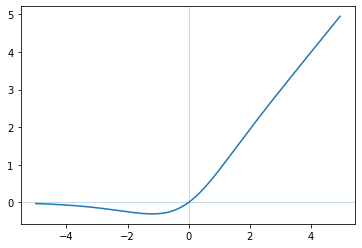

In [ ]:
plot_activations(x, a, 'plot')

# Training
## Binary Classification

In [ ]:
DIM = 2
metrics = [accuracy_score, 
           precision_score, 
           recall_score, 
           percent_positive,
           mean_soft_prediction
          ]

# Model starts out unfrozen and freezes last group startingn with epoch 3.
# This is not useful but is done here for testing purposes.
callbacks = [EarlyStopper('max', 'accuracy', patience=3),
             PerformanceThreshold('recall', 'max', 0.25, skip_epochs=5),
             MetricHistory(),
             ModelUnfreezer({3:1}, 'groups'),
             ModelCheckpoint(),
             MetricHistory(),
             CosineLRScheduler()
             S3Uploader('mytorch_test')
            ]

In [ ]:
train = Data(n=300, dim=DIM)
val = Data(n=30, dim=DIM)

dl_train = DataLoader(train, batch_size=8, shuffle=True)
dl_val = DataLoader(val, batch_size=8, shuffle=False)

In [ ]:
gnet = GroupedModel(DIM)
t = Trainer(gnet, train, val, dl_train, dl_val, F.binary_cross_entropy_with_logits, 
            'binary', '../data/v1', 'datascience-delphi-dev', torch.optim.RMSprop, 
            last_act=torch.sigmoid, metrics=metrics, callbacks=callbacks)
t

Trainer(criterion='binary_cross_entropy_with_logits', out_dir='../data/v1', bucket='datascience-delphi-dev')

Datasets: 300 train rows, 30 val rows

Optimizer: None

GroupedModel(
  (groups): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=8, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
    (1): Linear(in_features=4, out_features=1, bias=True)
  )
))

2020-02-14 17:06:46,155 [INFO]: Removing files from output directory.




2020-02-14 17:06:46,308
 
=====

Epoch 1

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.4308 |       0.2395 |
| accuracy             |  0.7933 |       0.8667 |
| precision            |  0.7367 |       1.0000 |
| recall               |  0.8413 |       0.7867 |
| percent_positive     |  0.5767 |       0.3667 |
| mean_soft_prediction |  0.5086 |       0.3790 |

=====

2020-02-14 17:06:46,309
 Saving model. Loss improved from inf to 0.2395.
Data written to ../data/v1/trainer.pkl.




2020-02-14 17:06:46,463
 
=====

Epoch 2

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.3729 |       0.4348 |
| accuracy             |  0.8467 |       0.8333 |
| precision            |  0.8354 |       0.7489 |
| recall               |  0.8556 |       1.0000 |
| percent_positive     |  0.5033 |       0.6667 |
| mean_soft_prediction |  0.4888 |       0.7262 |

=====

2020-02-14 17:06:46,464
 Epoch 3: Unfreezing last 1 groups.




2020-02-14 17:06:46,613
 
=====

Epoch 3

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.1912 |       0.1883 |
| accuracy             |  0.9300 |       0.9000 |
| precision            |  0.8893 |       1.0000 |
| recall               |  0.9867 |       0.8400 |
| percent_positive     |  0.5600 |       0.4000 |
| mean_soft_prediction |  0.5536 |       0.4145 |

=====

2020-02-14 17:06:46,614
 Saving model. Loss improved from 0.2395 to 0.1883.
Data written to ../data/v1/trainer.pkl.




2020-02-14 17:06:46,765
 
=====

Epoch 4

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.1331 |       0.1263 |
| accuracy             |  0.9367 |       0.9667 |
| precision            |  0.9342 |       0.9333 |
| recall               |  0.9620 |       1.0000 |
| percent_positive     |  0.5133 |       0.5333 |
| mean_soft_prediction |  0.5100 |       0.4703 |

=====

2020-02-14 17:06:46,766
 Saving model. Loss improved from 0.1883 to 0.1263.
Data written to ../data/v1/trainer.pkl.




2020-02-14 17:06:46,915
 
=====

Epoch 5

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.1165 |       0.1096 |
| accuracy             |  0.9367 |       0.9667 |
| precision            |  0.9249 |       0.9333 |
| recall               |  0.9387 |       1.0000 |
| percent_positive     |  0.5133 |       0.5333 |
| mean_soft_prediction |  0.5057 |       0.4992 |

=====

2020-02-14 17:06:46,916
 Saving model. Loss improved from 0.1263 to 0.1096.
Data written to ../data/v1/trainer.pkl.




2020-02-14 17:06:47,065
 
=====

Epoch 6

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.1154 |       0.1125 |
| accuracy             |  0.9300 |       0.9667 |
| precision            |  0.9324 |       0.9333 |
| recall               |  0.9409 |       1.0000 |
| percent_positive     |  0.5133 |       0.5333 |
| mean_soft_prediction |  0.5086 |       0.4795 |

=====




2020-02-14 17:06:47,222
 
=====

Epoch 7

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.1110 |       0.1186 |
| accuracy             |  0.9467 |       0.9667 |
| precision            |  0.9364 |       1.0000 |
| recall               |  0.9660 |       0.9467 |
| percent_positive     |  0.5100 |       0.4667 |
| mean_soft_prediction |  0.5090 |       0.4657 |

=====




2020-02-14 17:06:47,375
 
=====

Epoch 8

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.1141 |       0.1103 |
| accuracy             |  0.9367 |       0.9667 |
| precision            |  0.9373 |       0.9333 |
| recall               |  0.9397 |       1.0000 |
| percent_positive     |  0.5067 |       0.5333 |
| mean_soft_prediction |  0.5029 |       0.4783 |

=====

2020-02-14 17:06:47,376
 EarlyStopper halting training: validation accuracy has not improved enough in 4 epochs.

2020-02-14 17:06:47,377
 Training complete. Model in eval mode.


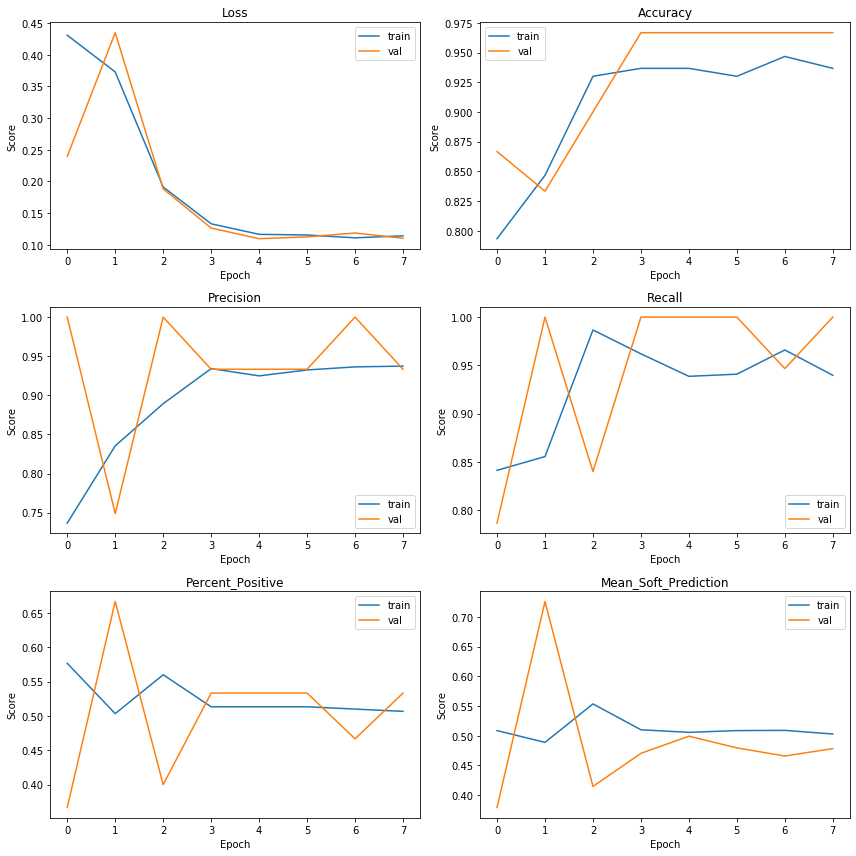

In [ ]:
t.fit(10, 3e-1, 0.5, clean=True)

In [ ]:
t.save('trainer.zip')

Data written to ../data/v1/trainer.zip.


In [ ]:
t2 = Trainer.from_file(os.path.join('..', 'data', 'v1', 'trainer.zip'))
print(t2)
del t2; gc.collect()

Object loaded from ../data/v1/trainer.zip.
Trainer(criterion='binary_cross_entropy_with_logits', out_dir='../data/v1', bucket='datascience-delphi-dev')

Datasets: 300 train rows, 30 val rows

Optimizer: RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 0.001
    lr: 0.09752016304205122
    momentum: 0
    weight_decay: 0

Parameter Group 1
    alpha: 0.99
    centered: False
    eps: 0.001
    lr: 0.19504032608410243
    momentum: 0
    weight_decay: 0
)

GroupedModel(
  (groups): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=8, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
    (1): Linear(in_features=4, out_features=1, bias=True)
  )
))


18311

## Multiclass classification

In [ ]:
class SimpleMulticlassModel(BaseModel):
    
    def __init__(self, dim, classes):
        super().__init__()  
        self.fc1 = nn.Linear(dim, 10)
        self.fc2 = nn.Linear(10, classes)
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        return self.fc2(x)

In [ ]:
DIM = 2
metrics = [accuracy_score,
           mean_soft_prediction
          ]

# Model starts out unfrozen and freezes last group startingn with epoch 3.
# This is not useful but is done here for testing purposes.
callbacks = [EarlyStopper('max', 'accuracy', patience=3),
             PerformanceThreshold('loss', 'min', 2, skip_epochs=5),
             MetricHistory(),
             ModelUnfreezer({3:2}, 'layers'),
             ModelCheckpoint(),
             MetricHistory(),
             CosineLRScheduler()
             S3Uploader('mytorch_test')
            ]

In [ ]:
train = MulticlassData(n=34, dim=DIM)
val = MulticlassData(n=30, dim=DIM)

dl_train = DataLoader(train, batch_size=8, shuffle=True)
dl_val = DataLoader(val, batch_size=8, shuffle=False)

In [ ]:
smnet = SimpleMulticlassModel(DIM, 5)
smnet

SimpleMulticlassModel(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=5, bias=True)
)



2020-02-14 16:58:00,398
 
=====

Epoch 1

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.5517 |       1.6642 |
| accuracy             |  0.3235 |       0.2667 |
| mean_soft_prediction |  0.2000 |       0.2000 |


2020-02-14 16:58:00,399
 Saving model. Loss improved from inf to 1.6642.
Data written to ../data/v2/trainer.pkl.




2020-02-14 16:58:00,430
 
=====

Epoch 2

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.4351 |       1.8731 |
| accuracy             |  0.2647 |       0.2667 |
| mean_soft_prediction |  0.2000 |       0.2000 |


2020-02-14 16:58:00,431
 Unfreezing last 2 layers.




2020-02-14 16:58:00,457
 
=====

Epoch 3

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.3237 |       1.8345 |
| accuracy             |  0.3529 |       0.3000 |
| mean_soft_prediction |  0.2000 |       0.2000 |





2020-02-14 16:58:00,485
 
=====

Epoch 4

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.2768 |       1.7265 |
| accuracy             |  0.4118 |       0.3667 |
| mean_soft_prediction |  0.2000 |       0.2000 |





2020-02-14 16:58:00,515
 
=====

Epoch 5

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.2725 |       1.6096 |
| accuracy             |  0.3824 |       0.4000 |
| mean_soft_prediction |  0.2000 |       0.2000 |


2020-02-14 16:58:00,515
 Saving model. Loss improved from 1.6642 to 1.6096.
Data written to ../data/v2/trainer.pkl.




2020-02-14 16:58:00,546
 
=====

Epoch 6

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.2853 |       1.6049 |
| accuracy             |  0.3235 |       0.3333 |
| mean_soft_prediction |  0.2000 |       0.2000 |


2020-02-14 16:58:00,547
 Saving model. Loss improved from 1.6096 to 1.6049.
Data written to ../data/v2/trainer.pkl.




2020-02-14 16:58:00,574
 
=====

Epoch 7

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.2391 |       1.6560 |
| accuracy             |  0.4118 |       0.3333 |
| mean_soft_prediction |  0.2000 |       0.2000 |





2020-02-14 16:58:00,599
 
=====

Epoch 8

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.2090 |       1.6696 |
| accuracy             |  0.4412 |       0.3000 |
| mean_soft_prediction |  0.2000 |       0.2000 |





2020-02-14 16:58:00,624
 
=====

Epoch 9

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  1.2167 |       1.6823 |
| accuracy             |  0.4118 |       0.3000 |
| mean_soft_prediction |  0.2000 |       0.2000 |


2020-02-14 16:58:00,625
 EarlyStopper halting training: validation accuracy has not improved enough in 4 epochs.

2020-02-14 16:58:00,626
 Training complete. Model in eval mode.


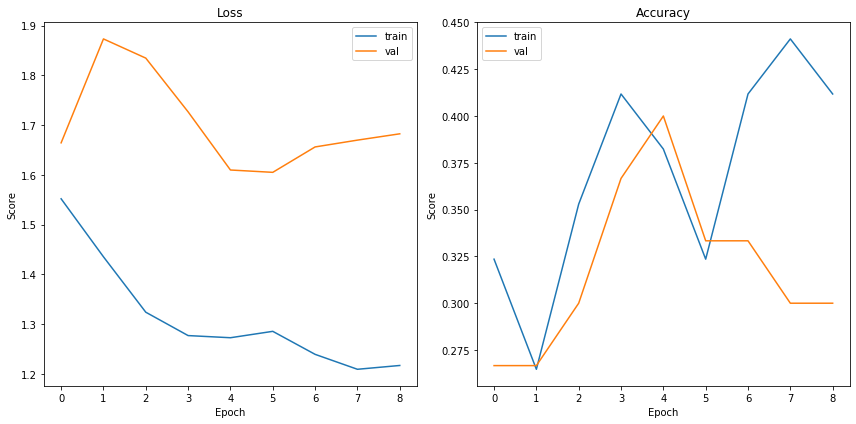

In [ ]:
t.fit(10, 3e-1)

### Scratch

In [ ]:
*x, y = next(iter(dl_train))
x, y

([tensor([[0.5219, 0.1604],
          [0.1135, 0.4161],
          [0.3907, 0.3769],
          [0.9464, 0.3559],
          [0.0547, 0.3759],
          [0.0930, 0.3026],
          [0.0189, 0.5636],
          [0.3094, 0.2666]])], tensor([2, 0, 0, 2, 0, 0, 0, 1]))

In [ ]:
yhat = smnet(*x)
yhat

tensor([[-0.0467, -0.0801,  0.4771, -0.1857,  0.2001],
        [ 0.0752, -0.0900,  0.3997, -0.3018,  0.1799],
        [ 0.0133, -0.1059,  0.4362, -0.2662,  0.2148],
        [-0.1016, -0.1393,  0.5033, -0.2052,  0.2878],
        [ 0.0808, -0.0785,  0.3978, -0.2938,  0.1649],
        [ 0.0617, -0.0693,  0.4109, -0.2671,  0.1590],
        [ 0.1163, -0.1104,  0.3881, -0.3379,  0.1813],
        [ 0.0125, -0.0808,  0.4401, -0.2375,  0.1854]],
       grad_fn=<AddmmBackward>)

In [ ]:
y.shape, yhat.shape

(torch.Size([8]), torch.Size([8, 5]))

In [ ]:
F.softmax(yhat, dim=-1)

tensor([[0.1722, 0.1666, 0.2908, 0.1499, 0.2205],
        [0.1989, 0.1686, 0.2752, 0.1364, 0.2209],
        [0.1854, 0.1646, 0.2830, 0.1402, 0.2268],
        [0.1620, 0.1560, 0.2967, 0.1461, 0.2392],
        [0.2000, 0.1705, 0.2745, 0.1375, 0.2175],
        [0.1954, 0.1714, 0.2771, 0.1407, 0.2154],
        [0.2078, 0.1657, 0.2727, 0.1320, 0.2218],
        [0.1848, 0.1683, 0.2834, 0.1439, 0.2196]], grad_fn=<SoftmaxBackward>)

In [ ]:
yhat.shape, y.shape

(torch.Size([8, 5]), torch.Size([8]))

In [ ]:
F.cross_entropy(yhat, y)

tensor(1.5432, grad_fn=<NllLossBackward>)

In [ ]:
t = Trainer(smnet, train, val, dl_train, dl_val, F.cross_entropy, 'multiclass',
        '../data/v2', 'datascience-delphi-dev', last_act=partial(F.softmax, dim=-1),
            metrics=metrics, callbacks=callbacks)
t

Trainer(criterion='cross_entropy', out_dir='../data/v2', bucket='datascience-delphi-dev')

Datasets: 34 train rows, 30 val rows

Optimizer: None

SimpleMulticlassModel(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=5, bias=True)
))